In [1]:
import sys
import os

# go up 1 folder level (from notebooks/ to project root)
sys.path.append(os.path.abspath(".."))

import gpxpy
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from math import radians, sin, cos, sqrt, atan2

from src.course_model import (
    build_full_course_model,
)

In [2]:
gpx_file_path = '../data/Chianti course.gpx'

with open(gpx_file_path, 'r') as f:
    gpx = gpxpy.parse(f)

points = []

for track in gpx.tracks:
    for segment in track.segments:
        for point in segment.points:
            points.append({
                'lat': point.latitude,
                'lon': point.longitude,
                'elev': point.elevation,
                'time': point.time
            })

df = pd.DataFrame(points)
df.head()

,lat,lon,elev,time
0,43.486612,11.374433,532.386719,NaT
1,43.486612,11.374433,532.386719,NaT
2,43.486655,11.374519,532.851562,2021-06-07 14:13:24+00:00
3,43.486741,11.374712,533.753906,NaT
4,43.486807,11.374849,533.503906,NaT


In [3]:
# --------------------------
# TEMPORARY GPX distance helper
# --------------------------

def haversine(lat1, lon1, lat2, lon2):
    R = 6371000  # meters
    phi1, phi2 = radians(lat1), radians(lat2)
    dphi = radians(lat2 - lat1)
    dlambda = radians(lon2 - lon1)

    a = sin(dphi/2)**2 + cos(phi1)*cos(phi2)*sin(dlambda/2)**2
    return 2 * R * atan2(sqrt(a), sqrt(1 - a))

def compute_cum_distance(df):
    distances = [0]  # first point is zero

    for i in range(1, len(df)):
        d = haversine(
            df.loc[i-1, 'lat'], df.loc[i-1, 'lon'],
            df.loc[i, 'lat'], df.loc[i, 'lon']
        )
        distances.append(d)

    df['segment_distance'] = distances
    df['cum_distance'] = df['segment_distance'].cumsum()
    return df

df = compute_cum_distance(df)

In [4]:
# 1. Hard elevation floor (<200m → NaN)
df["elev_clean"] = df["elev"].astype(float)
df.loc[df["elev_clean"] < 200, "elev_clean"] = np.nan
df["elev_clean"] = df["elev_clean"].interpolate().bfill().ffill()

# 2. Smooth
from scipy.signal import savgol_filter
df["elev_smooth"] = savgol_filter(df["elev_clean"], window_length=11, polyorder=3)

In [5]:
df_res, seg, key_climbs, course_summary, segment_summaries, climb_summaries = \
    build_full_course_model(df)

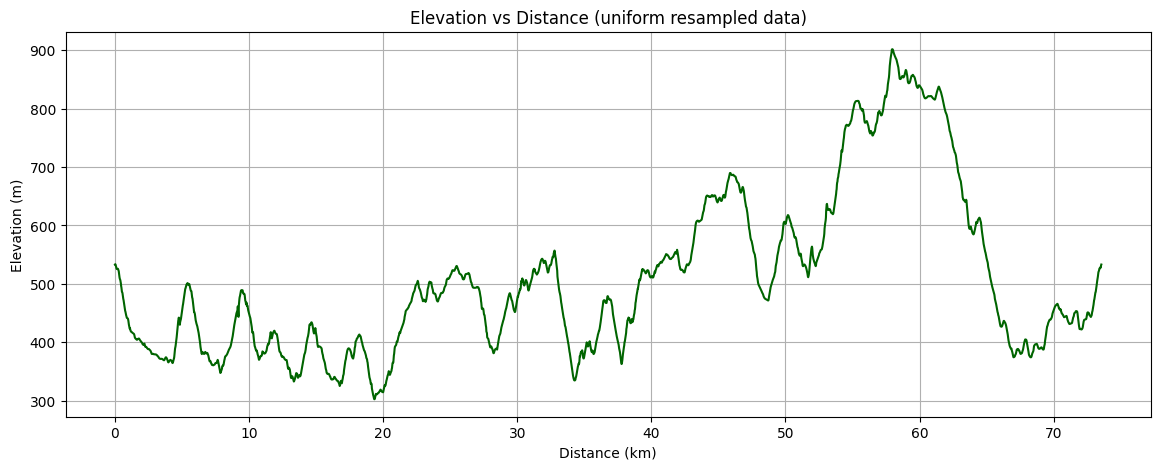

In [6]:
plt.figure(figsize=(14,5))
plt.plot(df_res["cum_distance"]/1000, df_res["elev_smooth"], color="darkgreen")
plt.title("Elevation vs Distance (uniform resampled data)")
plt.xlabel("Distance (km)")
plt.ylabel("Elevation (m)")
plt.grid(True)
plt.show()

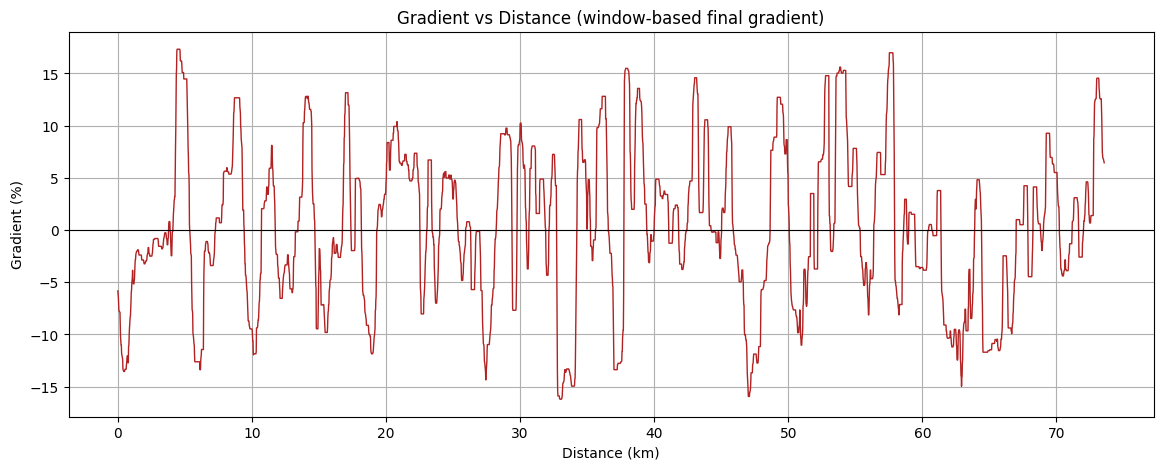

In [7]:
plt.figure(figsize=(14,5))
plt.plot(df_res["cum_distance"]/1000, df_res["gradient_final"], color="firebrick", linewidth=1)
plt.axhline(0, color="black", linewidth=0.8)
plt.title("Gradient vs Distance (window-based final gradient)")
plt.xlabel("Distance (km)")
plt.ylabel("Gradient (%)")
plt.grid(True)
plt.show()

In [8]:
course_summary

{'total_distance_km': 73.6,
 'total_gain_m': 3032,
 'total_loss_m': 3032,
 'num_segments': 124}

In [9]:
from src.race_strategy_generator import generate_race_strategy
from src.athlete_profile import get_default_athlete_profile

athlete_profile = get_default_athlete_profile()

strategy_text, strategy_data = generate_race_strategy(
    course_summary=course_summary,
    segment_summaries=segment_summaries,
    climb_summaries=climb_summaries,
    athlete_profile=athlete_profile,
)

print(strategy_text[:1000])  # first 1000 chars, just to inspect

TypeError: 'NoneType' object is not subscriptable

In [ ]:
strategy_data

In [ ]:
strategy_data.keys()
# -> dict_keys(['global_strategy', 'critical_sections', 'pacing_chunks', 'fueling_plan', 'mental_cues'])

In [ ]:
strategy_data["critical_sections"][:2]